In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Resizing, BatchNormalization, Lambda, Activation \
    ,Resizing, Rescaling, Dropout, InputLayer, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import os
import glob
import random
import shutil

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
IMAGES_DIR = os.path.join(".", "images_labeled")

In [5]:
ground_truth = pd.read_csv("./GroundTruth.csv")
ground_truth.iloc[:, 1:].sum()

MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64

In [6]:
os.chdir(IMAGES_DIR)
if os.path.isdir("train") is False:
    os.mkdir("train")
    os.mkdir("valid")
    os.mkdir("test")
    
    for col in ground_truth.iloc[:, 1:].columns:
        print(col)
        os.chdir(col)
        test_size = int(np.ceil(ground_truth.iloc[:, 1:].sum()[col] * .1))
        train_val_size = int(np.floor(ground_truth.iloc[:, 1:].sum()[col] * .9))
        train_size = int(np.ceil(train_val_size * .8))
        val_size = int(train_val_size - train_size)

        os.mkdir(os.path.join("..", "train", col))
        os.mkdir(os.path.join("..", "valid", col))
        os.mkdir(os.path.join("..", "test", col))

        train_file = glob.glob(col+'*')[:train_size]
        val_file = glob.glob(col+'*')[train_size:train_val_size]
        test_file = glob.glob(col+'*')[-test_size:]

        for img in train_file:
            shutil.move(img, os.path.join("..", "train", col))
        for img in val_file:
            shutil.move(img, os.path.join("..", "valid", col))
        for img in test_file:
            shutil.move(img, os.path.join("..", "test", col))

        os.chdir("..")
os.chdir("..")


In [7]:
TRAIN_PATH = os.path.join(IMAGES_DIR, "train")
VAL_PATH = os.path.join(IMAGES_DIR, "valid")
TEST_PATH = os.path.join(IMAGES_DIR, "test")

In [8]:
CLASSES = list(ground_truth.iloc[:, 1:].columns)
CLASSES

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [9]:
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='categorical',
    batch_size=25,
    image_size=(224,224)
)

val_ds = image_dataset_from_directory(
    VAL_PATH,
    label_mode='categorical',
    batch_size=25,
    image_size=(224,224)
)

Found 7212 files belonging to 7 classes.
Found 1798 files belonging to 7 classes.


In [10]:
train_ds.class_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [11]:
total_img = len(ground_truth)
cl_weight = {}
for i, cl in enumerate(train_ds.class_names):
    cl_weight[i] = total_img / (ground_truth.iloc[:, 1:].sum()[cl] * 7)
cl_weight


{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [12]:
from functools import partial

Conv2D3Kernel = partial(Conv2D, kernel_size=3, strides=1, padding='same', use_bias=False)

class ResUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            Conv2D3Kernel(filters, strides=strides),
            BatchNormalization(),
            self.activation,
            Conv2D3Kernel(filters),
            BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Conv2D3Kernel(filters, kernel_size=1, strides=strides),
                BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.main_layers:
            Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [13]:
def ResBlock(inputs, filters, strides=1):
    input_main = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters)(input_main)
    input_main = BatchNormalization()(input_main)

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(input_main + input_skip)
    

In [14]:
def DoubleResBlock(inputs, filters, strides=1):
    input_main = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main = BatchNormalization()(input_main)
    input_main = Activation(activation=keras.activations.relu)(input_main)
    input_main = Conv2D3Kernel(filters)(input_main)
    input_main = BatchNormalization()(input_main)

    input_main_2 = Conv2D3Kernel(filters, strides=strides)(inputs)
    input_main_2 = BatchNormalization()(input_main)
    input_main_2 = Activation(activation=keras.activations.relu)(input_main)
    input_main_2 = Conv2D3Kernel(filters)(input_main)
    input_main_2 = BatchNormalization()(input_main)

    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(input_main + input_main_2 + input_skip)

def ResNextBlock(inputs, filters, strides=1):
    input_main = []
    for i in range(8):
        temp_main = Conv2D3Kernel(filters/8, strides=strides)(inputs)
        temp_main = BatchNormalization()(temp_main)
        temp_main = Activation(activation=keras.activations.relu)(temp_main)
        temp_main = Conv2D3Kernel(filters)(temp_main)
        temp_main = BatchNormalization()(temp_main)
        input_main.append(temp_main)
    
    total_main = input_main[0]
    for item in input_main[1:]:
        total_main = total_main + item
    
    input_skip = inputs
    if strides > 1:
        input_skip = Conv2D3Kernel(filters, kernel_size=1, strides=strides)(input_skip)
        input_skip = BatchNormalization()(input_skip)
    return Activation(activation=keras.activations.relu)(total_main + input_skip)

In [15]:
input_layer = keras.layers.Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)
conv_1 = Conv2D(filters=32, kernel_size=(7, 7), strides=2, padding="valid", activation="relu")(rescaling)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D(pool_size=3)(conv_1)
maxpool_1 = tf.nn.local_response_normalization(maxpool_1)
resb_1 = ResNextBlock(maxpool_1, 32, 2)
resb_1 = ResNextBlock(resb_1, 32)
resb_1 = ResNextBlock(resb_1, 32)
resb_1 = ResNextBlock(resb_1, 64, 2)
resb_1 = ResNextBlock(resb_1, 64)
resb_1 = ResNextBlock(resb_1, 64)
resb_1 = ResNextBlock(resb_1, 80, 2)
resb_1 = ResNextBlock(resb_1, 80)
resb_1 = ResNextBlock(resb_1, 96, 2)
global_avg = GlobalAveragePooling2D()(resb_1)
flatten = Flatten()(global_avg)
output = Dense(7, activation="softmax")(flatten)
model = Model(inputs=[input_layer], outputs=[output])

with tf.device('/GPU:0'):
  model.compile(optimizer=keras.optimizers.Nadam(), loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.summary()

In [16]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, class_weight=cl_weight)

Epoch 1/20
289/289 [==============================] - 186s 419ms/step - loss: 1.9473 - accuracy: 0.3684 - val_loss: 2.6262 - val_accuracy: 0.0256
Epoch 2/20
289/289 [==============================] - 111s 383ms/step - loss: 1.6255 - accuracy: 0.4673 - val_loss: 1.4168 - val_accuracy: 0.6018
Epoch 3/20
289/289 [==============================] - 114s 392ms/step - loss: 1.5830 - accuracy: 0.4602 - val_loss: 8.9998 - val_accuracy: 0.0145
Epoch 4/20
289/289 [==============================] - 110s 381ms/step - loss: 1.4005 - accuracy: 0.5054 - val_loss: 1.6670 - val_accuracy: 0.2608
Epoch 5/20
289/289 [==============================] - 108s 373ms/step - loss: 1.2819 - accuracy: 0.5624 - val_loss: 2.7161 - val_accuracy: 0.1307
Epoch 6/20
289/289 [==============================] - 119s 412ms/step - loss: 1.2124 - accuracy: 0.5632 - val_loss: 1.9260 - val_accuracy: 0.1424
Epoch 7/20
289/289 [==============================] - 113s 390ms/step - loss: 1.1480 - accuracy: 0.5813 - val_loss: 1.5111 -

KeyboardInterrupt: 

In [ ]:
history2 = model.fit(train_ds, validation_data=val_ds, epochs=2, class_weight=cl_weight)

Epoch 1/2
271/271 [==============================] - 127s 468ms/step - loss: 0.2099 - accuracy: 0.8203 - val_loss: 1.3293 - val_accuracy: 0.5607
Epoch 2/2
271/271 [==============================] - 127s 468ms/step - loss: 0.4413 - accuracy: 0.7602 - val_loss: 1.5319 - val_accuracy: 0.5416


In [ ]:
history3 = model.fit(train_ds, validation_data=val_ds, epochs=2, class_weight=cl_weight)

Epoch 1/2
271/271 [==============================] - 127s 466ms/step - loss: 0.2569 - accuracy: 0.8074 - val_loss: 1.3402 - val_accuracy: 0.6003
Epoch 2/2
271/271 [==============================] - 128s 470ms/step - loss: 0.1451 - accuracy: 0.8611 - val_loss: 1.3206 - val_accuracy: 0.5954


In [ ]:
history4 = model.fit(train_ds, validation_data=val_ds, epochs=6, class_weight=cl_weight)

Epoch 1/6
271/271 [==============================] - 129s 475ms/step - loss: 0.2693 - accuracy: 0.8216 - val_loss: 1.6458 - val_accuracy: 0.5825
Epoch 2/6
271/271 [==============================] - 130s 477ms/step - loss: 0.2644 - accuracy: 0.8092 - val_loss: 1.2413 - val_accuracy: 0.5803
Epoch 3/6
271/271 [==============================] - 131s 480ms/step - loss: 0.1628 - accuracy: 0.8605 - val_loss: 1.3427 - val_accuracy: 0.6216
Epoch 4/6
271/271 [==============================] - 130s 479ms/step - loss: 0.1137 - accuracy: 0.8923 - val_loss: 1.4260 - val_accuracy: 0.6105
Epoch 5/6
271/271 [==============================] - 129s 473ms/step - loss: 0.0805 - accuracy: 0.9152 - val_loss: 1.6539 - val_accuracy: 0.6092
Epoch 6/6
271/271 [==============================] - 125s 461ms/step - loss: 0.1497 - accuracy: 0.8866 - val_loss: 1.5558 - val_accuracy: 0.5896


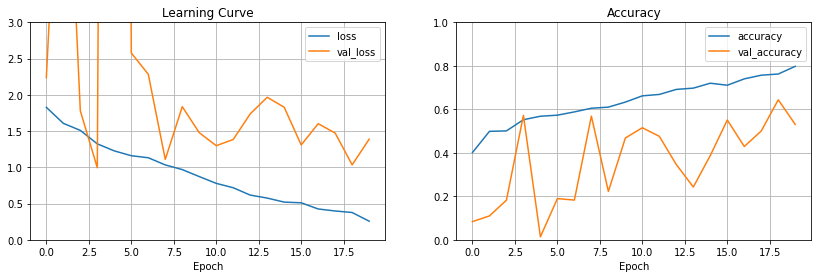

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.DataFrame(history.history)[["loss", 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.DataFrame(history.history)[["accuracy", 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

plt.show()

(0.0, 1.0)

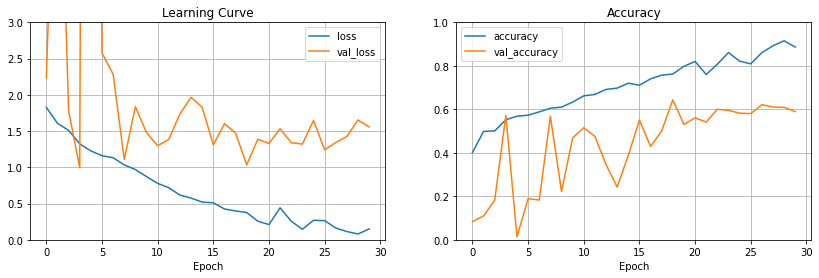

In [ ]:
h1 = pd.DataFrame(history.history)
h2 = pd.DataFrame(history2.history, index=[20, 21])
h3 = pd.DataFrame(history3.history, index=[22, 23])
h4 = pd.DataFrame(history4.history, index=[24, 25,26,27,28,29])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
pd.concat([h1,h2,h3, h4])[["loss", 'val_loss']].plot(ax=axes[0])
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epoch")
axes[0].grid(True)
axes[0].set_ylim([0,3])

pd.concat([h1,h2,h3, h4])[["accuracy", 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].set_ylim([0, 1])

In [ ]:
pd.concat([h1,h2,h3]).tail()

,loss,accuracy,val_loss,val_accuracy
19,0.256554,0.797811,1.388403,0.530458
20,0.209908,0.820293,1.329341,0.560694
21,0.441261,0.760243,1.531931,0.541574
22,0.256901,0.807425,1.340227,0.600267
23,0.145071,0.861115,1.320583,0.595376


In [ ]:
#model.save("skin_cancer_res_V1.h5")

In [ ]:
test_ds = image_dataset_from_directory(
    TEST_PATH,
    label_mode='categorical',
    batch_size=25,
    image_size=(224,224),
    shuffle=False
)

Found 1005 files belonging to 7 classes.


In [ ]:
pred = model.predict(test_ds)
pred

41/41 [==============================] - 6s 135ms/step


array([[3.3404012e-03, 1.2738328e-02, 5.4849255e-01, ..., 8.2430011e-03,
        3.7040359e-01, 3.0302783e-04],
       [3.3193800e-01, 5.3703034e-01, 2.0127714e-02, ..., 1.1348994e-02,
        9.6735276e-02, 8.1611041e-05],
       [7.8388155e-01, 2.1064255e-01, 1.4430766e-03, ..., 1.5302245e-06,
        4.0214919e-03, 5.0246290e-06],
       ...,
       [1.4635270e-09, 6.2357763e-08, 1.5566444e-06, ..., 5.5807362e-07,
        2.2421314e-05, 9.9997532e-01],
       [1.1810919e-07, 2.7998828e-09, 6.0619706e-01, ..., 2.6623608e-04,
        6.9652246e-03, 3.8657135e-01],
       [9.0033486e-03, 1.1469179e-02, 7.9500582e-04, ..., 3.6996880e-03,
        3.1316725e-03, 2.6247252e-04]], dtype=float32)

In [ ]:
y_true = []
for X, y in test_ds:
    for d in y:
        y_true.append(d.numpy())
y_true = np.array(y_true)

In [ ]:
y_true_a = np.argmax(y_true, axis=1)
y_pred_a = np.argmax(pred, axis=1)

In [ ]:
y_pred_a

array([2, 1, 0, ..., 6, 2, 3], dtype=int64)

[]

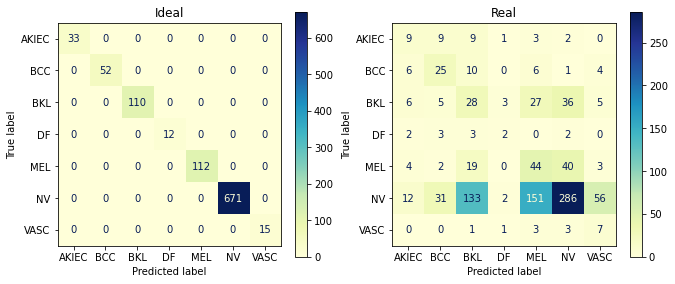

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf = confusion_matrix(y_true_a, y_pred_a)
ideal = confusion_matrix(y_true_a, y_true_a)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(11, 4.5)
ConfusionMatrixDisplay(ideal, display_labels=train_ds.class_names).plot(cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Ideal")
ConfusionMatrixDisplay(cf, display_labels=train_ds.class_names).plot(cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Real")
plt.plot()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

print(accuracy_score(y_true_a, y_pred_a))
f1_score(y_true_a, y_pred_a, average="weighted")

0.3990049751243781


0.44796321789995697